In [14]:
import matplotlib.pyplot as plt
import numpy as np
import particle.literals as pl
from scipy.integrate import quad, nquad
import pandas as pd

plt.rcParams.update({
    "text.usetex": True,
    #"font.family": "Helvetica"
})

from scipy.special import spence
li2 = lambda x: spence(1-x)

In [2]:
me = pl.e_minus.mass / 1000
mmu = pl.mu_minus.mass / 1000
mtau = pl.tau_minus.mass / 1000

a_em = 1/137
s2W = 0.23121

fa = 1000

## 1-loop Yukawa diagram

* Giudice, Paradisi, Passera [1208.6583](https://arxiv.org/abs/1208.6583); Cherchiglia, Kneschke, Stöckinger, Stöckinger-Kim [1607.06292](https://arxiv.org/abs/1607.06292) $$a_\ell^\mathrm{1 loop} = -\frac{m_\ell^2}{16\pi^2 f_a^2} \frac{2}{x_\ell}\int_0^1 dz\frac{z^3}{1-z+z^2/x_\ell}$$
* Galda, Neubert [2308.01338](https://arxiv.org/abs/2308.01338) $$a_\ell^\mathrm{1 loop} = - \frac{m_\ell^2}{16\pi^2 f_a^2} \left[1 +2x_\ell +x_\ell(1-x_\ell)\log x_\ell-2x_\ell(3-x_\ell)\sqrt{\frac{x_\ell}{4-x_\ell}}\arccos\frac{\sqrt{x_\ell}}{2}\right]$$

In [3]:
def alep_1loop_GPP(ma, mlep):
    return -mlep**4/(8*np.pi**2*fa**2*ma**2)*quad(lambda z: z**3/(1-z+z**2*mlep**2/ma**2), 0, 1)[0]

def alep_1loop_GN(ma, mlep):
    x = ma**2/mlep**2+1e-10j
    if x<100:
        return -mlep**2/(16*np.pi**2*fa**2)*(1+2*x+x*(1-x)*np.log(x)-2*x*(3-x)*np.sqrt(x/(4-x))*np.arccos(0.5*np.sqrt(x)))
    else:
        return -mlep**2/(16*np.pi**2*fa**2)*(np.log(x)-11/6)*2/x

/home/jorge/.local/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jorge/.local/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


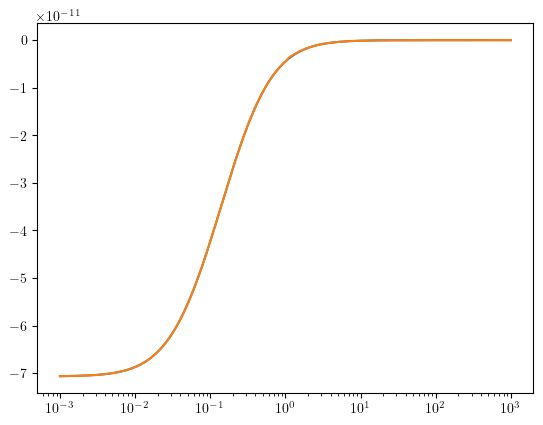

In [4]:
plt.semilogx([10**x for x in np.linspace(-3, 3, 200)], [alep_1loop_GPP(10**x, mmu)  for x in np.linspace(-3, 3, 200)])
plt.semilogx([10**x for x in np.linspace(-3, 3, 200)], [alep_1loop_GN(10**x, mmu)  for x in np.linspace(-3, 3, 200)])

## 2-loop

* Giudice, Paradisi, Passera [1208.6583](https://arxiv.org/abs/1208.6583) $$a_\ell^\mathrm{2loops}=\frac{\alpha m_\ell^2 c_\ell c_\tau}{8\pi^3 f_a^2}\frac{1}{x_\tau}\int_0^1 dz \frac{1}{z(1-z)-1/x_\tau}\log[x_\tau z(1-z)]$$

* Cherchiglia, Kneschke, Stöckinger, Stöckinger-Kim [1607.06292](https://arxiv.org/abs/1607.06292) $$a_\ell^\mathrm{2loops}=\frac{\alpha m_\ell^2c_\ell c_\tau}{4\pi^3 f_a^2}\frac{1}{x_\tau}\frac{\Phi(m_a, m_\tau)}{m_a^2-4m_\tau^2}$$ $$\alpha_+=\frac{m_a^2}{2m_\tau^2}\left(1-\sqrt{1-\frac{4m_\tau^2}{m_a^2}}\right)$$ $$\alpha_-=1-\frac{m_a^2}{2m_\tau^2}\left(1+\sqrt{1-\frac{4m_\tau^2}{m_a^2}}\right)$$ $$\Phi(m_a, m_\tau) = m_a^2\sqrt{1-\frac{4m_\tau^2}{m_a^2}} \left[\log \alpha_+ \log\alpha_- - \mathrm{Li}_2 \alpha_+ - \mathrm{Li}_2\alpha_- +\frac{\pi^2}{6}\right]$$

In [5]:
def alep_2loops_GPP(ma, mlep):
    return sum(a_em*mlep**2*mtau**2/(8*np.pi**3*fa**2*ma**2)*quad(lambda z: np.log(z*(1-z)*ma**2/mloop**2)/(z*(1-z)-mloop**2/ma**2), 0, 1)[0] for mloop in [mtau])

def alep_2loops_CKSS(ma, mlep):
    if ma < 2* mtau:
        beta = np.sqrt(4*mtau**2/ma**2-1)*1j
    else:
        beta = np.sqrt(1-4*mtau**2/ma**2)
    aplus = 0.5*ma**2/mtau**2*(1-beta)
    aminus = 1-0.5*ma**2/mtau**2*(1+beta)
    phi = np.real(ma**2*beta*(np.log(aplus)*np.log(aminus+1e-10j)-li2(aplus+1e-10j)-li2(aminus)+np.pi**2/6))
    return a_em*mlep**2*mtau**2/(4*np.pi**3*fa**2*ma**2)*phi/(ma**2-4*mtau**2)
    #return phi

def h2(x):
    if np.real(x) > 8:
        return np.log(x)+1.5
    x *= (1+1e-10j)
    return 1 - x/3 +x**2/6*np.log(x)+(2+x)/3*np.sqrt(x*(4-x))*np.arccos(0.5*np.sqrt(x))

def alep_2loops_GN(ma, mlep):
    xlep = ma**2/mlep**2+1e-10j
    atot = 0
    for mloop in [me, mmu, mtau]:
        xloop = ma**2/mloop**2+1e-10j
        F = lambda y, x: 1/(1-y)*(h2(x)-h2(x/y))
        atot -= a_em*mlep**2/(8*np.pi**3*fa**2)*quad(lambda z: F(z*(1-z)*xloop, xlep), 0, 1, complex_func=True)[0]
    return atot

def alep_2loops_BPTZ(ma, mlep):
    atot = 0
    for mloop in [me, mmu, mtau]:
        def f(x, y, z):
            u = ma**2/mlep**2
            v = ma**2/mloop**2
            return u*x/(u*(1-x)+u*v*x*y*z*(1-z)+v*z*(1-z)*x**2*(1-y)**2)
    atot += a_em*mlep**2/(8*np.pi**3*fa**2)*nquad(f, [[0,1], [0,1], [0,1]])[0]

def alep_gammaeff(ma, mlep, c0=0):
    Lam = 4*np.pi*fa
    return -mlep**2*a_em*3/(8*np.pi**3*fa**2)*(3+c0)*(np.log(Lam**2/mlep**2)-h2(ma**2/mlep**2))

def alep_gammaZeff(ma, mlep):
    Lam = 4*np.pi*fa
    c_gammaZ = -1.5/(s2W*(1-s2W))**0.5
    return -mlep**2*a_em*c_gammaZ*(1-4*s2W)/(8*np.pi**3*fa**2)*(np.log(Lam**2/mlep**2)-1.5)

def alep_lbl(ma, mlep, c0=0):
    Lam = 4*np.pi*fa
    g_agg = 3*a_em/(np.pi*fa)
    return 3*a_em**3/np.pi*mlep**2*(c0+1)**2/(16*np.pi**5*fa**2)*np.log(Lam/ma)**2

def alep_lbl_tau(ma, mlep, c0=0):
    Lam = 4*np.pi*fa
    return 3*a_em**3/np.pi*mlep**2*(c0+1)**2/(16*np.pi**5*fa**2)*np.log(Lam/ma)**2

def only_real(z):
    if abs(np.imag(z)) > 1e-3:
        return float('nan')
    else:
        return z

/home/jorge/.local/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:447: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  re_retval = quad(refunc, a, b, args, full_output, epsabs,
/home/jorge/.local/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jorge/.local/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.001, 1000.0)

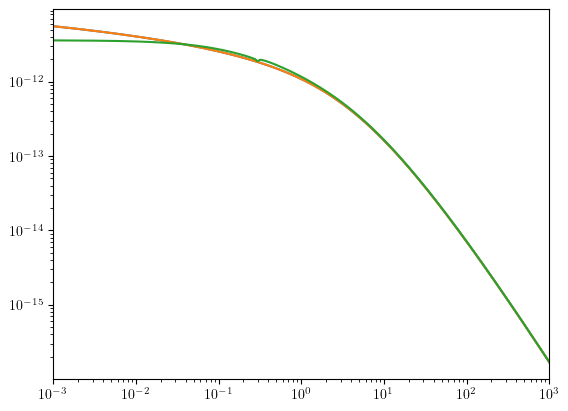

In [6]:
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [alep_2loops_GPP(10**x, mmu)  for x in np.linspace(-3, 3, 200)])
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [alep_2loops_CKSS(10**x, mmu)  for x in np.linspace(-3, 3, 200)])
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [alep_2loops_GN(10**x, mmu)  for x in np.linspace(-3, 3, 200)])
plt.xlim(1e-3, 1e3)

In [7]:
def phi(ma):
    if ma < 2* mtau:
        beta = np.sqrt(4*mtau**2/ma**2-1)*1j
    else:
        beta = np.sqrt(1-4*mtau**2/ma**2)
    aplus = 0.5*ma**2/mtau**2*(1-beta)
    aminus = 1-0.5*ma**2/mtau**2*(1+beta)
    return np.real(ma**2*beta*(np.log(aplus)*np.log(aminus+1e-10j)-li2(aplus+1e-10j)-li2(aminus)+np.pi**2/6))

def phi_approx(ma):
    if ma < 2* mtau:
        beta = np.sqrt(4*mtau**2/ma**2-1)*1j
    else:
        beta = np.sqrt(1-4*mtau**2/ma**2)
    aplus = 0.5*ma**2/mtau**2*(1-beta)
    aminus = 1-0.5*ma**2/mtau**2*(1+beta)
    #return np.real(ma**2*(-li2(aplus+1e-10j)-li2(aminus)+np.pi**2/6))
    return li2(aplus+1e-5j)+li2(aminus)

In [8]:
ae = [np.real(alep_1loop_GN(10**x, me)+alep_2loops_CKSS(10**x, me)+alep_gammaeff(10**x, me)+alep_lbl(10**x, me)) for x in np.linspace(-3, 3, 200)]
amu = [np.real(alep_1loop_GN(10**x, mmu)+alep_2loops_CKSS(10**x, mmu)+alep_gammaeff(10**x, mmu)+alep_lbl(10**x, mmu)) for x in np.linspace(-3, 3, 200)]
atau = [np.real(alep_1loop_GN(10**x, mtau)+alep_2loops_CKSS(10**x, mtau)+alep_gammaeff(10**x, mtau)+alep_lbl(10**x, mtau)) for x in np.linspace(-3, 3, 200)]

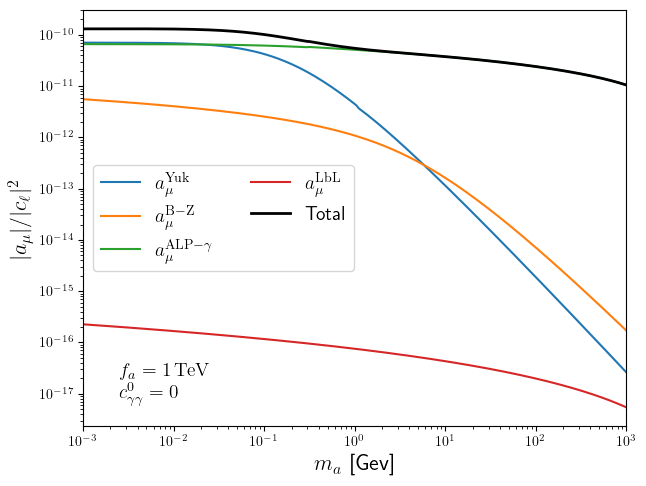

In [9]:
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [np.abs(alep_1loop_GN(10**x, mmu)) for x in np.linspace(-3, 3, 200)], label=r'$a_\mu^\mathrm{Yuk}$')
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [np.abs(alep_2loops_CKSS(10**x, mmu)) for x in np.linspace(-3, 3, 200)], label = r'$a_\mu^\mathrm{B-Z}$')
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [np.abs(alep_gammaeff(10**x, mmu)) for x in np.linspace(-3, 3, 200)], label = r'$a_\mu^{\mathrm{ALP-}\gamma}$')
#plt.semilogx([10**x for x in np.linspace(-3, 3, 200)], [alep_gammaZeff(10**x, mmu) for x in np.linspace(-3, 3, 200)], label = '1 loop Z')
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [np.abs(alep_lbl(10**x, mmu)) for x in np.linspace(-3, 3, 200)], label=r'$a_\mu^\mathrm{LbL}$')
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [np.abs(sum(alep(10**x, mmu) for alep in [alep_1loop_GN, alep_2loops_CKSS, alep_gammaeff, alep_lbl])) for x in np.linspace(-3, 3, 200)], label='Total', c='k', lw=2)
plt.xlim(1e-3, 1e3)
plt.xlabel(r'$m_a$ [Gev]', fontsize=16)
plt.ylabel(r'$|a_\mu|/|c_\ell|^2$', fontsize=16)
plt.annotate(r'$f_a = 1\,\mathrm{TeV}$' + '\n' + r'$c_{\gamma\gamma}^0=0$', (2.5e-3, 0.8e-17), fontsize=14)
plt.legend(fontsize=14, ncols=2)
plt.tight_layout(pad=0.5)
plt.savefig('g2mu_contributions.pdf')

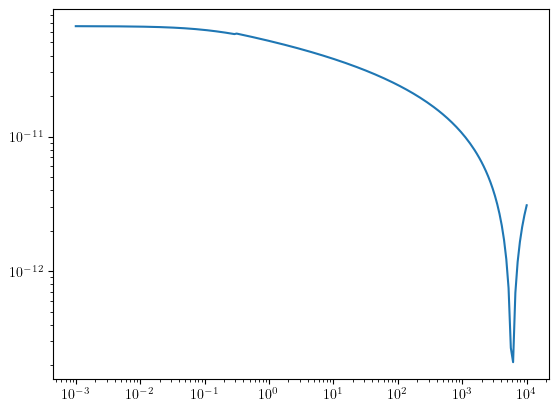

In [10]:
plt.loglog([10**x for x in np.linspace(-3, 4, 200)], [np.abs(alep_gammaeff(10**x, mmu)) for x in np.linspace(-3, 4, 200)], label = '1 loop effective photon coupling')

(-1e-11, 1e-11)

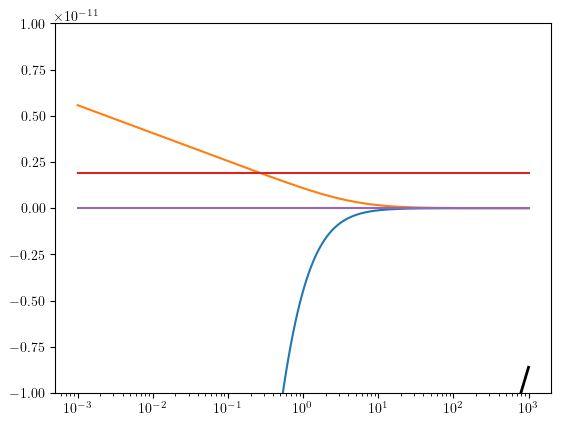

In [11]:
plt.semilogx([10**x for x in np.linspace(-3, 3, 200)], [alep_1loop_GPP(10**x, mmu) for x in np.linspace(-3, 3, 200)], label='1 loop Yukawa')
plt.semilogx([10**x for x in np.linspace(-3, 3, 200)], [alep_2loops_GPP(10**x, mmu) for x in np.linspace(-3, 3, 200)], label = '2 loop Barr-Zee')
plt.semilogx([10**x for x in np.linspace(-3, 3, 200)], [alep_gammaeff(10**x, mmu) for x in np.linspace(-3, 3, 200)], label = '1 loop photon')
plt.semilogx([10**x for x in np.linspace(-3, 3, 200)], [alep_gammaZeff(10**x, mmu) for x in np.linspace(-3, 3, 200)], label = '1 loop Z')
plt.semilogx([10**x for x in np.linspace(-3, 3, 200)], [alep_lbl(10**x, mmu) for x in np.linspace(-3, 3, 200)], label='2 loop lbl')
plt.semilogx([10**x for x in np.linspace(-3, 3, 200)], [sum(alep(10**x, mmu) for alep in [alep_1loop_GPP, alep_2loops_GPP, alep_gammaeff, alep_gammaZeff, alep_lbl]) for x in np.linspace(-3, 3, 200)], label='Total', c='k', lw=2)
plt.ylim(-1e-11, 1e-11)

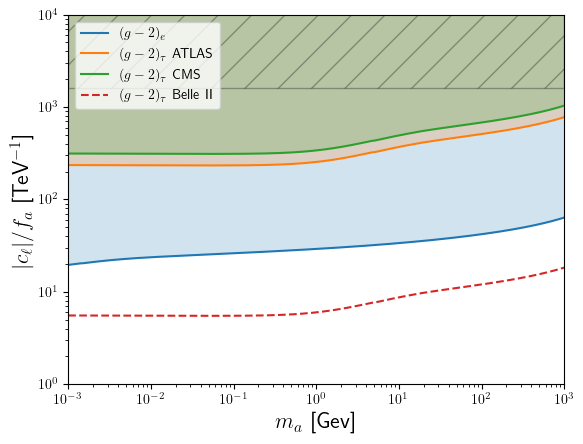

In [12]:
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [(1e-12/np.abs(a))**0.5 for a in ae], label=r'$(g-2)_e$')
plt.fill_between([10**x for x in np.linspace(-3, 3, 200)], [(1e-12/np.abs(a))**0.5 for a in ae], 1e4, alpha=0.2)
#plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [only_real(((2.49e-9+3*0.48e-9)/a)**0.5) for a in amu], label=r'$(g-2)_\mu$')
#plt.fill_between([10**x for x in np.linspace(-3, 3, 200)], [only_real(((2.49e-9+3*0.48e-9)/a)**0.5) for a in amu], 1e4, alpha=0.2)
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [(1.8e-3/np.abs(a))**0.5 for a in atau], label=r'$(g-2)_\tau$ ATLAS')
plt.fill_between([10**x for x in np.linspace(-3, 3, 200)], [(1.8e-3/np.abs(a))**0.5 for a in atau], 1e4, alpha=0.2)
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [(3.2e-3/np.abs(a))**0.5 for a in atau], label=r'$(g-2)_\tau$ CMS')
plt.fill_between([10**x for x in np.linspace(-3, 3, 200)], [(3.2e-3/np.abs(a))**0.5 for a in atau], 1e4, alpha=0.2)
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [(1e-6/np.abs(a))**0.5 for a in atau], label=r'$(g-2)_\tau$ Belle II', ls='dashed')
plt.fill_between([1e-3, 1e3], [1000*np.sqrt(8*np.pi/3)/mtau, 1000*np.sqrt(8*np.pi/3)/mtau], [2e4, 2e4],  hatch='/', color='none', edgecolor='k', alpha=0.3)
plt.xlim(1e-3, 1e3)
plt.ylim(1, 1e4)
plt.xlabel(r'$m_a$ [Gev]', fontsize=16)
plt.ylabel(r'$|c_\ell|/f_a$ [TeV$^{-1}$]', fontsize=16)
plt.legend()

In [21]:
pd.DataFrame({'ma_GeV': [10**x for x in np.linspace(-3, 3, 200)], 'c_g2tau_ATLAS': [(1.8e-3/np.abs(a))**0.5 for a in atau], 'c_g2tau_BelleII': [(1e-6/np.abs(a))**0.5 for a in atau],  'c_g2tau_CMS24': [(3.2e-3/np.abs(a))**0.5 for a in atau]}).to_csv('../data/anomalous_moments/g2tau_lfu.csv', index=False)
pd.DataFrame({'ma_GeV': [10**x for x in np.linspace(-3, 3, 200)], 'c_g2e': [(1e-12/np.abs(a))**0.5 for a in ae]}).to_csv('../data/anomalous_moments/g2e.csv', index=False)
pd.DataFrame({'ma_GeV': [10**x for x in np.linspace(-3, 3, 200)], 'c_g2mu': [only_real(((2.49e-9+3*0.48e-9)/a)**0.5) for a in amu]}).to_csv('../data/anomalous_moments/g2mu.csv', index=False)

/tmp/ipykernel_7486/4053064386.py:3: RuntimeWarning: invalid value encountered in scalar power
  pd.DataFrame({'ma_GeV': [10**x for x in np.linspace(-3, 3, 200)], 'c_g2mu': [only_real(((2.49e-9+3*0.48e-9)/a)**0.5) for a in amu]}).to_csv('../data/anomalous_moments/g2mu.csv', index=False)


Text(0, 0.5, '$|c_\\tau|/f_a$ [TeV$^{-1}$]')

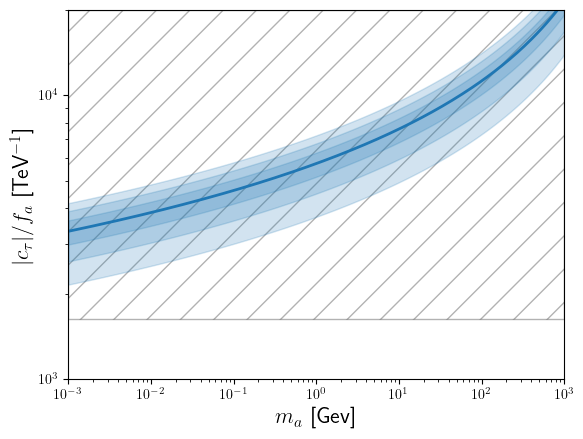

In [17]:
plt.fill_between([1e-3, 1e3], [1000*np.sqrt(8*np.pi/3)/mtau, 1000*np.sqrt(8*np.pi/3)/mtau], [2e4, 2e4],  hatch='/', color='none', edgecolor='k', alpha=0.3)
plt.fill_between([10**x for x in np.linspace(-3, 3, 200)], [only_real(((2.49e-9+0.48e-9)/alep_lbl_tau(10**x, mmu))**0.5) for x in np.linspace(-3, 3, 200)], [only_real(((2.49e-9-0.48e-9)/alep_lbl_tau(10**x, mmu))**0.5) for x in np.linspace(-3, 3, 200)], color='tab:blue', alpha=0.2)
plt.fill_between([10**x for x in np.linspace(-3, 3, 200)], [only_real(((2.49e-9+2*0.48e-9)/alep_lbl_tau(10**x, mmu))**0.5) for x in np.linspace(-3, 3, 200)], [only_real(((2.49e-9-2*0.48e-9)/alep_lbl_tau(10**x, mmu))**0.5) for x in np.linspace(-3, 3, 200)], color='tab:blue', alpha=0.2)
plt.fill_between([10**x for x in np.linspace(-3, 3, 200)], [only_real(((2.49e-9+3*0.48e-9)/alep_lbl_tau(10**x, mmu))**0.5) for x in np.linspace(-3, 3, 200)], [only_real(((2.49e-9-3*0.48e-9)/alep_lbl_tau(10**x, mmu))**0.5) for x in np.linspace(-3, 3, 200)], color='tab:blue', alpha=0.2)
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [only_real(((2.49e-9)/alep_lbl_tau(10**x, mmu))**0.5) for x in np.linspace(-3, 3, 200)], label=r'$(g-2)_\mu$', lw=2)
plt.xlim(1e-3, 1e3)
plt.ylim(1e3, 2e4)
plt.xlabel(r'$m_a$ [Gev]', fontsize=16)
plt.ylabel(r'$|c_\tau|/f_a$ [TeV$^{-1}$]', fontsize=16)

In [18]:
ae_5p = [np.real(alep_1loop_GN(10**x, me)+alep_2loops_CKSS(10**x, me)+alep_gammaeff(10**x, me, 5)+alep_lbl(10**x, me)) for x in np.linspace(-3, 3, 200)]
amu_5p = [np.real(alep_1loop_GN(10**x, mmu)+alep_2loops_CKSS(10**x, mmu)+alep_gammaeff(10**x, mmu, 5)+alep_lbl(10**x, mmu)) for x in np.linspace(-3, 3, 200)]
atau_5p = [np.real(alep_1loop_GN(10**x, mtau)+alep_2loops_CKSS(10**x, mtau)+alep_gammaeff(10**x, mtau, 5)+alep_lbl(10**x, mtau)) for x in np.linspace(-3, 3, 200)]

ae_5m = [np.real(alep_1loop_GN(10**x, me)+alep_2loops_CKSS(10**x, me)+alep_gammaeff(10**x, me, -5)+alep_lbl(10**x, me)) for x in np.linspace(-3, 3, 200)]
amu_5m = [np.real(alep_1loop_GN(10**x, mmu)+alep_2loops_CKSS(10**x, mmu)+alep_gammaeff(10**x, mmu, -5)+alep_lbl(10**x, mmu)) for x in np.linspace(-3, 3, 200)]
atau_5m = [np.real(alep_1loop_GN(10**x, mtau)+alep_2loops_CKSS(10**x, mtau)+alep_gammaeff(10**x, mtau, -5)+alep_lbl(10**x, mtau)) for x in np.linspace(-3, 3, 200)]

/tmp/ipykernel_7486/3482625140.py:13: RuntimeWarning: invalid value encountered in scalar power
  plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [only_real(((2.49e-9+3*0.48e-9)/a)**0.5) for a in amu], label=r'$(g-2)_\mu$', lw=2.5)
/tmp/ipykernel_7486/3482625140.py:14: RuntimeWarning: invalid value encountered in scalar power
  plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [only_real(((2.49e-9+3*0.48e-9)/a)**0.5) for a in amu_5p], ls='dotted', c='tab:purple', lw=1)
/tmp/ipykernel_7486/3482625140.py:15: RuntimeWarning: invalid value encountered in scalar power
  plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [only_real(((2.49e-9+3*0.48e-9)/a)**0.5) for a in amu_5m], ls='dashed', c='tab:purple', lw=1)


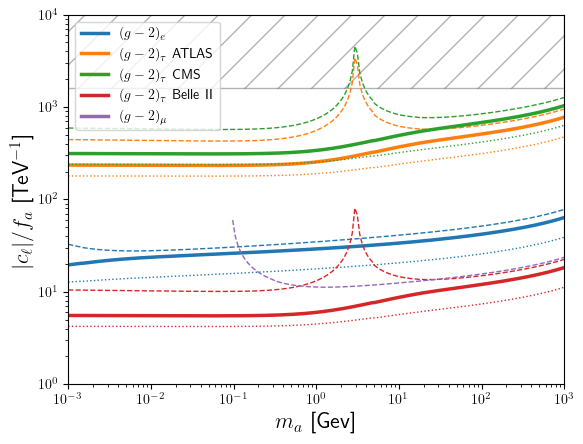

In [19]:
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [(1e-12/np.abs(a))**0.5 for a in ae], label=r'$(g-2)_e$', lw=2.5)
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [(1e-12/np.abs(a))**0.5 for a in ae_5p], ls='dotted', c='tab:blue', lw=1)
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [(1e-12/np.abs(a))**0.5 for a in ae_5m], ls='dashed', c='tab:blue', lw=1)
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [(1.8e-3/np.abs(a))**0.5 for a in atau], label=r'$(g-2)_\tau$ ATLAS', lw=2.5)
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [(1.8e-3/np.abs(a))**0.5 for a in atau_5p], ls='dotted', c='tab:orange', lw=1)
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [(1.8e-3/np.abs(a))**0.5 for a in atau_5m], ls='dashed', c='tab:orange', lw=1)
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [(3.2e-3/np.abs(a))**0.5 for a in atau], label=r'$(g-2)_\tau$ CMS', lw=2.5)
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [(3.2e-3/np.abs(a))**0.5 for a in atau_5p], ls='dotted', c='tab:green', lw=1)
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [(3.2e-3/np.abs(a))**0.5 for a in atau_5m], ls='dashed', c='tab:green', lw=1)
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [(1e-6/np.abs(a))**0.5 for a in atau], label=r'$(g-2)_\tau$ Belle II', lw=2.5)
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [(1e-6/np.abs(a))**0.5 for a in atau_5p], ls='dotted', c='tab:red', lw=1)
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [(1e-6/np.abs(a))**0.5 for a in atau_5m], ls='dashed', c='tab:red', lw=1)
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [only_real(((2.49e-9+3*0.48e-9)/a)**0.5) for a in amu], label=r'$(g-2)_\mu$', lw=2.5)
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [only_real(((2.49e-9+3*0.48e-9)/a)**0.5) for a in amu_5p], ls='dotted', c='tab:purple', lw=1)
plt.loglog([10**x for x in np.linspace(-3, 3, 200)], [only_real(((2.49e-9+3*0.48e-9)/a)**0.5) for a in amu_5m], ls='dashed', c='tab:purple', lw=1)
plt.fill_between([1e-3, 1e3], [1000*np.sqrt(8*np.pi/3)/mtau, 1000*np.sqrt(8*np.pi/3)/mtau], [2e4, 2e4],  hatch='/', color='none', edgecolor='k', alpha=0.3)
plt.xlim(1e-3, 1e3)
plt.ylim(1, 1e4)
plt.xlabel(r'$m_a$ [Gev]', fontsize=16)
plt.ylabel(r'$|c_\ell|/f_a$ [TeV$^{-1}$]', fontsize=16)
plt.legend()

In [20]:
pd.DataFrame({'ma_GeV': [10**x for x in np.linspace(-3, 3, 200)],
             'cl_g2e+cgg': [(1e-12/np.abs(a))**0.5 for a in ae_5m],
             'cl_g2e-cgg': [(1e-12/np.abs(a))**0.5 for a in ae_5p],
             'cl_g2mu+cgg': [only_real(((2.49e-9+3*0.48e-9)/a)**0.5) for a in amu_5m],
             'cl_g2mu-cgg': [only_real(((2.49e-9+3*0.48e-9)/a)**0.5) for a in amu_5p],
             'cl_g2tauBII+cgg': [(1e-6/np.abs(a))**0.5 for a in atau_5m],
             'cl_g2tauBII-cgg': [(1e-6/np.abs(a))**0.5 for a in atau_5p],
             'cl_g2tauATLAS+cgg': [(1.8e-3/np.abs(a))**0.5 for a in atau_5m],
             'cl_g2tauATLAS-cgg': [(1.8e-3/np.abs(a))**0.5 for a in atau_5p],}).to_csv('../data/anomalous_moments/g2_cgg.csv', index=False)

/tmp/ipykernel_7486/1646176953.py:4: RuntimeWarning: invalid value encountered in scalar power
  'cl_g2mu+cgg': [only_real(((2.49e-9+3*0.48e-9)/a)**0.5) for a in amu_5m],
/tmp/ipykernel_7486/1646176953.py:5: RuntimeWarning: invalid value encountered in scalar power
  'cl_g2mu-cgg': [only_real(((2.49e-9+3*0.48e-9)/a)**0.5) for a in amu_5p],
